In [1]:
#%%
import re
import os
# add the parent directory to the path
import sys
sys.path.append('../../')
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal
from utils import *
import seaborn as sns

folder_path = '../experiment_data/tk_11092023'

exp_layout = {0:(0,['B','C','D']),
              10**-2:(0,['E','F','G']),
              10**-1:(1,['B','C','D']),
              10**0:(1,['E','F','G']),
              10**1:(2,['B','C','D']),
              10**2:(2,['E','F','G'])}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


rfu30_to_dilution = cal.run()

In [2]:
def get_timeseries(folder_path,plate_num):
    """Takes a folder of excel files and returns a list of plates and a list of data
    Each element in the list corresponds to a plate scan.
    Specify plate num to get the data from a specific excel sheet.

    Args:
        folder_path (str): path to the folder containing the excel files
        plate_num (int): the excel sheet number corresponding to the plate

    Returns:
        list: list of plate objects
        list: list of dictionaries containing the data
    """
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement',sheet_name=plate_num)
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

In [3]:
# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_raw = {}
cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,10))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key]
            # col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t,background_subtracted=False)
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)
    cell_count_raw[exp_key] = cell_count_data

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

dict_t = {'time':time,
          'mean':mean_dict,
          'err':err_dict,
          'cell_count_mean':cell_count_mean,
          'cell_count_err':cell_count_err,
          'cell_count_log_err':cell_count_log_err}

# save as pickle

with open('data_11092023.pickle','wb') as f:
    pickle.dump(dict_t,f)


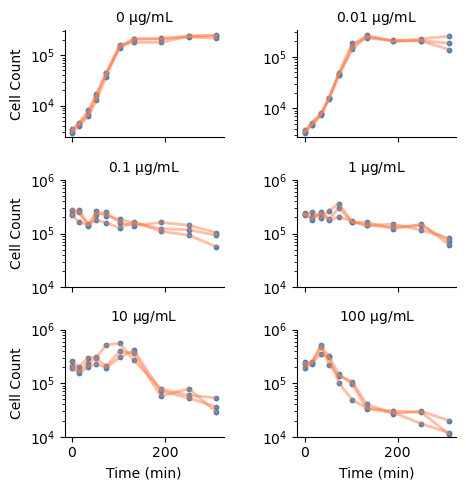

In [4]:
fig,ax_list = plt.subplots(nrows=3,ncols=2,figsize=(5,5),sharex=True)
ax_list = ax_list.flatten()

row_indx = 0
for key in cell_count_mean.keys():
    ax = ax_list[row_indx]
    cell_count_t = cell_count_raw[key]

    for i in range(3):
        ax.scatter(time,cell_count_t[i,:],color='steelblue',alpha=1,s=10)
        ax.plot(time,cell_count_t[i,:],color='coral',alpha=0.5,linewidth=2)
        
    # ax.errorbar(time,cell_count_mean[key],yerr=cell_count_err[key],fmt='o',label=key)
    # ax.scatter(time,mean_dict[key],label=key)
    # ax.set_xscale('log')
    ax.set_title(str(key) + ' $\mathrm{\mu}$g/mL',fontsize=10)
    ax.set_yscale('log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    row_indx += 1

ax_list[4].set_xlabel('Time (min)')
ax_list[5].set_xlabel('Time (min)')

ax_list[0].set_ylabel('Cell Count')
ax_list[2].set_ylabel('Cell Count')
ax_list[4].set_ylabel('Cell Count')
fig.tight_layout()

for ax in ax_list[2:]:
    ax.set_ylim(10**4,10**6)

fig.savefig('../../figures/time_kill_11092023_cell_count.pdf',bbox_inches='tight')

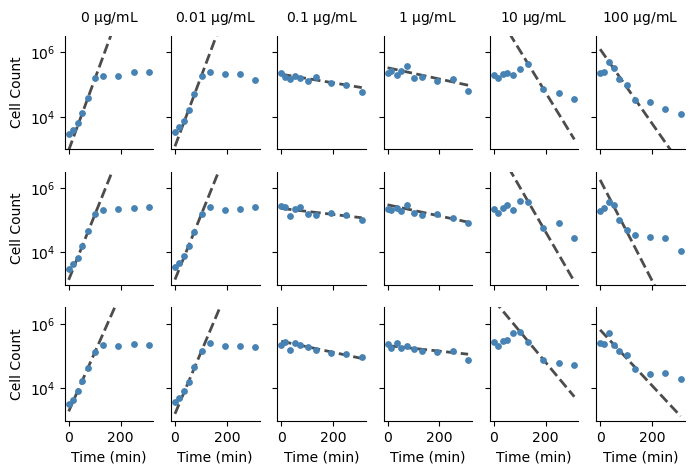

In [5]:
# options = {'window':2,'step':1,'exclude':3,'thresh':0.25}
options = {'window':2,'step':1,'exclude':3,'thresh':0.5}

thresh_list = [0.6,0.5,0.25,0.25,0.6,0.4]

n_replicates = 3
n_conditions = len(cell_count_mean.keys())

fig,ax_list = plt.subplots(nrows=n_replicates,ncols=n_conditions,figsize=(8,5),sharex=True,sharey=True)

time_fit = np.linspace(0,np.max(time),100)

gr_dict = {}

conc_list = []

row_indx = 0
for key in cell_count_mean.keys():

    slope_est = []
    options['thresh'] = thresh_list[row_indx]
    for i in range(n_replicates):
        cell_count_t = cell_count_raw[key][i]
        fit = est_linear_slope(cell_count_t,time=time,debug=True,return_fit=True,**options)

        ax = ax_list[i,row_indx]
        ax.scatter(time,cell_count_t,color='steelblue',alpha=1,s=15)

        if type(fit) == tuple:
            fit_t = time*fit[0] + fit[1]
            fit_t = np.e**fit_t
            ax.plot(time,fit_t,'--',color='black',alpha=0.7,linewidth=2,zorder=-1)
            
        slope_est.append(fit[0])
        
    ax.set_yscale('log')

    dict_t = {'avg':np.mean(slope_est),'err':np.std(slope_est)/np.sqrt(len(slope_est))}
    gr_dict[key] = dict_t
    conc_list.append(key)

    row_indx += 1

for ax in ax_list.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yscale('log')
    ax.set_ylim(10**3,10**6.5)

# for ax in ax_list[:,0:2].flatten():
#     ax.set_ylim(10**3,10**6)

# for ax in ax_list[:,2:].flatten():
#     ax.set_ylim(10**4,10**6)


for ax in ax_list[:,0]:
    ax.set_ylabel('Cell Count')

for ax in ax_list[-1,:]:
    ax.set_xlabel('Time (min)')

for i,ax in enumerate(ax_list[0,:]):
    ax.set_title(str(conc_list[i]) + ' $\mathrm{\mu}$g/mL',fontsize=10,pad=10)

fig.savefig('../../figures/raw_data_with_fit.pdf',bbox_inches='tight')


In [6]:
# do the same for AUC

auc_dict = {}

for key in cell_count_mean.keys():

    auc_est = []
    for i in range(n_replicates):
        y = np.log10(cell_count_raw[key][i])
        y = y/y[0]
        auc_est.append(np.trapz(time,y))
    
    dict_t = {'avg':np.mean(auc_est),'err':np.std(auc_est)/np.sqrt(len(auc_est))}
    auc_dict[key] = dict_t

# normalize for conc = 0
max_auc = auc_dict[0]['avg']
for key in auc_dict.keys():
    auc_dict[key]['avg'] = auc_dict[key]['avg']/max_auc
    auc_dict[key]['err'] = auc_dict[key]['err']/max_auc

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_19453/2172494496.py:21: RuntimeWarning: invalid value encountered in scalar power
  g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))


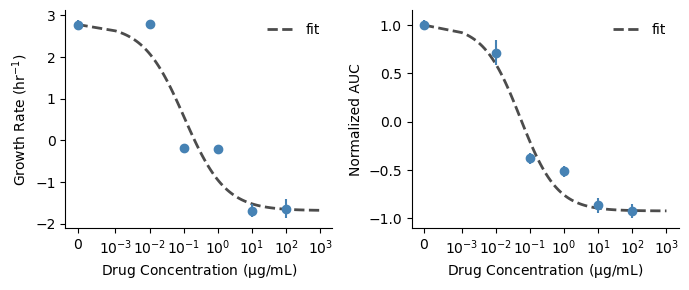

In [7]:
def pharmacodynamic_curve(c, gmax, gmin, mic, k):
    """pharmacodynamic model adapted from Foerster et al.

    Foerster, S., Unemo, M., Hathaway, L.J. et al. Time-kill curve analysis and
    pharmacodynamic modelling for in vitro evaluation of antimicrobials against Neisseria
    gonorrhoeae . BMC Microbiol 16, 216 (2016). 
    https://doi.org/10.1186/s12866-016-0838-9

    Args:
        c (float): drug concentration
        gmax (float): max growth rate
        gmin (float): min growth rate
        mic (float): estimated minimum inhibitory concentration
        k (float): hill coefficient
    """
    g = []
    for c_t in c:
        if c_t == 0:
            g.append(gmax)
        else:
            g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))
    
    return g

fig,ax_list = plt.subplots(ncols=2,figsize=(7,3))

ax = ax_list[0]

gr_mean = []
for key in gr_dict.keys():
    y = np.array(gr_dict[key]['avg'])*60
    err = np.array(gr_dict[key]['err'])*60
    ax.errorbar(key,y,yerr=err,fmt='o',color='steelblue',alpha=1)
    gr_mean.append(gr_dict[key]['avg'])

gr_mean = np.array(gr_mean)
conc_list = np.array(list(gr_dict.keys()))

gmin = np.min(gr_mean)
gmax = np.max(gr_mean)

# p0 = [gmax_est,gmin_est,0.1,1]

p0 = [1,0.1]
popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                        conc_list,gr_mean,p0=p0,maxfev=100000)

conc_fit = np.logspace(-3,3,100)
# append 0 to the beginning of the array
conc_fit = np.insert(conc_fit,0,0)
gr_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])

gr_fit = np.array(gr_fit)*60

ax.plot(conc_fit,gr_fit,'--',color='black',alpha=0.7,linewidth=2,zorder=-1,label='fit')

ax.set_xscale('symlog',linthresh=0.001)

ax.legend(frameon=False)
ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
ax.set_ylabel('Growth Rate (hr$^{-1}$)')

# do the same for AUC

ax = ax_list[1]

auc_mean = []
for key in auc_dict.keys():
    ax.errorbar(key,auc_dict[key]['avg'],yerr=auc_dict[key]['err'],fmt='o',color='steelblue',alpha=1)
    auc_mean.append(auc_dict[key]['avg'])

auc_mean = np.array(auc_mean)
conc_list = np.array(list(auc_dict.keys()))

gmin = np.min(auc_mean)
gmax = np.max(auc_mean)

p0 = [0.1,1]
popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                        conc_list,auc_mean,p0=p0,maxfev=100000)

conc_fit = np.logspace(-3,3,100)

# append 0 to the beginning of the array
conc_fit = np.insert(conc_fit,0,0)

# auc_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,0.1,1)
auc_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])

ax.plot(conc_fit,auc_fit,'--',color='black',alpha=0.7,linewidth=2,zorder=-1,label='fit')

ax.set_xscale('symlog',linthresh=0.001)
ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
ax.set_ylabel('Normalized AUC')

ax.legend(frameon=False)

# remove right and top spines
for ax in ax_list:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()

# fig.savefig('../../figures/pharmacodynamic_fit.pdf',bbox_inches='tight')

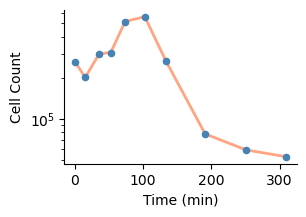

In [8]:
# plot one of the time series for the method figure

fig,ax = plt.subplots(figsize=(3,2))

key = 10

cell_count_t = cell_count_raw[key][2]

ax.scatter(time,cell_count_t,color='steelblue',alpha=1,s=20)
ax.plot(time,cell_count_t,color='coral',alpha=0.7,linewidth=2,zorder=-1)
ax.set_yscale('log')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Cell Count')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig('../../figures/time_kill_11092023_example.png',bbox_inches='tight',dpi=300)

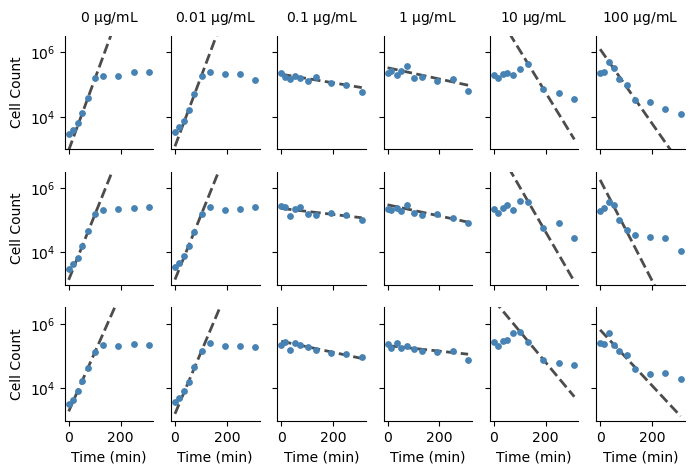

In [9]:
# options = {'window':2,'step':1,'exclude':3,'thresh':0.25}
options = {'window':2,'step':1,'exclude':3,'thresh':0.5}

thresh_list = [0.6,0.5,0.25,0.25,0.7,0.45]

n_replicates = 3
n_conditions = len(cell_count_mean.keys())

fig,ax_list = plt.subplots(nrows=n_replicates,ncols=n_conditions,figsize=(8,5),sharex=True,sharey=True)

time_fit = np.linspace(0,np.max(time),100)

gr_dict = {}

conc_list = []

row_indx = 0
for key in cell_count_mean.keys():

    slope_est = []
    options['thresh'] = thresh_list[row_indx]
    for i in range(n_replicates):
        cell_count_t = cell_count_raw[key][i]
        # if cell_count_t[-1] > cell_count_t[0]:
        #     print(options)
        #     fit = est_linear_slope(cell_count_t,time=time,debug=True,return_fit=True,**options)

        # else:
        #     max_indx = np.argmax(cell_count_t)
        #     ydata_fit = cell_count_t[max_indx:]
        #     xdata_fit = time[max_indx:]
        #     res = stats.linregress(xdata_fit,np.log(ydata_fit))
        #     fit = (res[0],res[1])

        fit = est_linear_slope(cell_count_t,time=time,debug=True,return_fit=True,**options)

        ax = ax_list[i,row_indx]
        ax.scatter(time,cell_count_t,color='steelblue',alpha=1,s=15)

        if type(fit) == tuple:
            fit_t = time*fit[0] + fit[1]
            fit_t = np.e**fit_t
            ax.plot(time,fit_t,'--',color='black',alpha=0.7,linewidth=2,zorder=-1)
            
        slope_est.append(fit[0])
        
    ax.set_yscale('log')

    dict_t = {'avg':np.mean(slope_est),'err':np.std(slope_est)/np.sqrt(len(slope_est))}
    gr_dict[key] = dict_t
    conc_list.append(key)

    row_indx += 1

for ax in ax_list.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yscale('log')
    ax.set_ylim(10**3,10**6.5)

# for ax in ax_list[:,0:2].flatten():
#     ax.set_ylim(10**3,10**6)

# for ax in ax_list[:,2:].flatten():
#     ax.set_ylim(10**4,10**6)


for ax in ax_list[:,0]:
    ax.set_ylabel('Cell Count')

for ax in ax_list[-1,:]:
    ax.set_xlabel('Time (min)')

for i,ax in enumerate(ax_list[0,:]):
    ax.set_title(str(conc_list[i]) + ' $\mathrm{\mu}$g/mL',fontsize=10,pad=10)

# fig.savefig('../../figures/raw_data_with_fit.pdf',bbox_inches='tight')


/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_19453/2172494496.py:21: RuntimeWarning: invalid value encountered in scalar power
  g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))


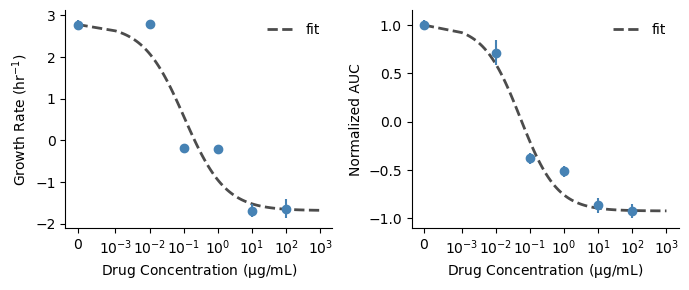

In [10]:
def pharmacodynamic_curve(c, gmax, gmin, mic, k):
    """pharmacodynamic model adapted from Foerster et al.

    Foerster, S., Unemo, M., Hathaway, L.J. et al. Time-kill curve analysis and
    pharmacodynamic modelling for in vitro evaluation of antimicrobials against Neisseria
    gonorrhoeae . BMC Microbiol 16, 216 (2016). 
    https://doi.org/10.1186/s12866-016-0838-9

    Args:
        c (float): drug concentration
        gmax (float): max growth rate
        gmin (float): min growth rate
        mic (float): estimated minimum inhibitory concentration
        k (float): hill coefficient
    """
    g = []
    for c_t in c:
        if c_t == 0:
            g.append(gmax)
        else:
            g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))
    
    return g

fig,ax_list = plt.subplots(ncols=2,figsize=(7,3))

ax = ax_list[0]

gr_mean = []
for key in gr_dict.keys():
    y = np.array(gr_dict[key]['avg'])*60
    err = np.array(gr_dict[key]['err'])*60
    ax.errorbar(key,y,yerr=err,fmt='o',color='steelblue',alpha=1)
    gr_mean.append(gr_dict[key]['avg'])

gr_mean = np.array(gr_mean)
conc_list = np.array(list(gr_dict.keys()))

gmin = np.min(gr_mean)
gmax = np.max(gr_mean)

# p0 = [gmax_est,gmin_est,0.1,1]

p0 = [1,0.1]
popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                        conc_list,gr_mean,p0=p0,maxfev=100000)

conc_fit = np.logspace(-3,3,100)
# append 0 to the beginning of the array
conc_fit = np.insert(conc_fit,0,0)
gr_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])

gr_fit = np.array(gr_fit)*60

ax.plot(conc_fit,gr_fit,'--',color='black',alpha=0.7,linewidth=2,zorder=-1,label='fit')

ax.set_xscale('symlog',linthresh=0.001)

ax.legend(frameon=False)
ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
ax.set_ylabel('Growth Rate (hr$^{-1}$)')

# do the same for AUC

ax = ax_list[1]

auc_mean = []
for key in auc_dict.keys():
    ax.errorbar(key,auc_dict[key]['avg'],yerr=auc_dict[key]['err'],fmt='o',color='steelblue',alpha=1)
    auc_mean.append(auc_dict[key]['avg'])

auc_mean = np.array(auc_mean)
conc_list = np.array(list(auc_dict.keys()))

gmin = np.min(auc_mean)
gmax = np.max(auc_mean)

p0 = [0.1,1]
popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                        conc_list,auc_mean,p0=p0,maxfev=100000)

conc_fit = np.logspace(-3,3,100)

# append 0 to the beginning of the array
conc_fit = np.insert(conc_fit,0,0)

# auc_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,0.1,1)
auc_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])

ax.plot(conc_fit,auc_fit,'--',color='black',alpha=0.7,linewidth=2,zorder=-1,label='fit')

ax.set_xscale('symlog',linthresh=0.001)
ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
ax.set_ylabel('Normalized AUC')

ax.legend(frameon=False)

# remove right and top spines
for ax in ax_list:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()

# fig.savefig('../../figures/pharmacodynamic_fit.pdf',bbox_inches='tight')

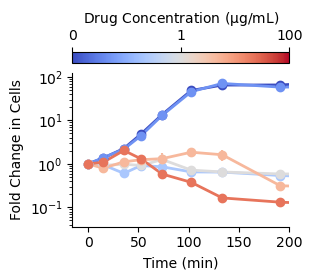

In [17]:
# cmap = sns.color_palette("colorblind", as_cmap=True)
# vridis colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)


fig,ax = plt.subplots(figsize=(2.8,2.5))

for j,key in enumerate(cell_count_mean.keys()):

    cell_count_t = np.zeros((n_replicates,len(time)))
    for i in range(n_replicates):
        cell_count_t[i,:] = cell_count_raw[key][i]/cell_count_raw[key][i,0]
        # ax.plot(time,cell_count_t,color=cmap[j])
    
    # mean
    cell_count_mean_t = np.mean(cell_count_t,axis=0)

    # err
    cell_count_err_t = np.std(cell_count_t,axis=0)/np.sqrt(n_replicates)

    ax.errorbar(time,cell_count_mean_t,yerr=cell_count_err_t*np.sqrt(3),fmt='o',color=cmap(j/6),label=key)
    ax.plot(time,cell_count_mean_t,color=cmap(j/6),alpha=1,linewidth=2)

    ax.set_yscale('log')

    row_indx += 1

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),ax=ax,location='top')
cbar.set_ticks([0,0.5,1])
cbar.set_ticklabels([0,1,10**2])
cbar.set_label('Drug Concentration ($\mathrm{\mu}$g/mL)')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Fold Change in Cells')

xl = ax.get_xlim()
ax.set_xlim(xl[0],200)

fig.savefig('../../figures/time_kill_11092023_fold_change.pdf',bbox_inches='tight')
